# Clustering of selected terms in corpus
## Abstract
Clustering terms from a corpus involves grouping similar or related terms together. This process aims to highlight significant concepts within the corpus and their interconnections.
It constitutes the second phase of content analysis and follows the ['text_mining'](./text_mining.ipynb) notebook.

Similarly, we shall first reproduce the method used by the software VOSviewer, which is the standard for content analysis on a corpus of documents, here scientific papers. We then move on to exploring new strategies inspired by recent developments in AI, for instance embeddings.

According to [VOSviewer publications](https://www.vosviewer.com/publications#technical-publications), the [association strength metric](http://dx.doi.org/10.1002/asi.21075) is used to normalize the binary cooccurence matrix (of keywords, authors...). Once normalized, the [VOS](http://dx.doi.org/10.1007/978-3-540-70981-7_34) (visualization of simalirty) clustering method is applied.

## Disclaimer
It wasn't my part of the work and since my partner decided to abandon me whitout any notice, the project is a mess because it was supposed to be a team project, and I had to work on this a day prior to the deadline. An helpful reminder that better alone than in bad company. If there is a mismatch in motivation, work ehtics and ambitions, it will go sour. It wasn't for a lack of trying, I set up a drive for shared documents, a GitHub for collaborative work, and shared my progress.  I've even tried to establish aggrements on shared deadlines.

What were the results of my attempts ? Not a single document from my partner, not a single git commit, no words of progress, only of "couldn't work I was doing something else". What about the shared deadlines ? He didn't give a care and didn't even tell me that he hadn't done anything or couldn't make it without me reaching for him. 

It is true that I did not come to school very often, as I feel mentally bad at this specific school, but we could have tried to setup other places to meet. There were other solutions than just abandonning me without a word leaving me stuck and worried.



## Dependencies

In [1]:
# reloading python scripts
import importlib

# utils
import utils
importlib.reload(utils)
from utils import scan_df, write_df, read_df

# performant multidimensional array computation
import jax.numpy as jnp
import jax
import numpy as np

import scipy

# performant dataframes
import polars as pl

In [2]:
# Notebook Config
%xmode Minimal

Exception reporting mode: Minimal


## Applying VOSviewer text mining
We apply the text mining implemented by VOSviewer for extracting relevant terms from a corpus. The method is described in the ['text_mining'](./text_mining.ipynb) notebook.

The `text_mining.vos_viewer` method returns both the coocurence matrix of relevant terms and a dataframe describing those relevants terms.

In [3]:
import text_mining
importlib.reload(text_mining)

vos_miner_res = text_mining.vos_viewer(
    scan_df("papers"), 
    doc_id="Id",
    text_cols=[
        "Subject",
        "Abstract",
        "Keywords"
    ],
    binary_occurences=True,
    relevance_threshold=0
)
write_df("relevant_terms", vos_miner_res.relevant_terms)

Identifying terms...
Done in 1e+01s.
Computing relevant terms...
Done in 3.4s.


### Relevant terms dataframe

In [4]:
(
    vos_miner_res.relevant_terms
    .sort("relevance", descending=True)
)

id,term,doc_ids,count,paper_count,relevance
u32,str,list[i64],u32,u32,f32
830,"""rap aggregate""","[470, 470, … 470]",8,1,0.108802
840,"""homogeneity""","[470, 470, … 470]",7,1,0.108802
841,"""virgin""","[470, 470, … 470]",7,1,0.108802
862,"""dm""","[216, 216, … 216]",6,1,0.090614
870,"""social licence""","[29, 29, … 29]",6,1,0.08313
…,…,…,…,…,…
123,"""improvement""","[299, 112, … 373]",24,23,0.049976
1,"""study""","[169, 219, … 298]",306,191,0.049864
113,"""carbon emission""","[487, 171, … 171]",55,24,0.049744


### Relevant terms co-occurences
The co-occurence matrix described in [_How to normalize cooccurence data ?_](http://dx.doi.org/10.1002/asi.21075) is made from a binary occurence matrix. As we used a non binary occurence matrix in the text_mining.vosviewer method, let's get one here and then compute the coocurrence matrix.

#### Binary occurences matrix
The rows are the terms and the columns are the papers.

In [5]:
selected_terms = (
        scan_df("relevant_terms")
        .sort("relevance", descending=True)
        .head(266)
        .sort("count", descending=True)
        .collect()
)
write_df("selected_terms", selected_terms)
selected_terms

id,term,doc_ids,count,paper_count,relevance
u32,str,list[i64],u32,u32,f32
19,"""internet""","[365, 53, … 437]",112,70,0.059411
35,"""iot""","[216, 322, … 477]",78,53,0.062069
51,"""thing""","[188, 149, … 77]",51,43,0.06206
54,"""things""","[35, 98, … 178]",50,42,0.064057
132,"""ai""","[289, 201, … 201]",41,21,0.059994
…,…,…,…,…,…
757,"""cultural heritage""","[59, 59, … 495]",6,3,0.059305
697,"""structural element""","[266, 409, … 73]",6,5,0.059212
766,"""generation""","[423, 126, … 423]",6,3,0.059155


In [6]:
import text_mining
importlib.reload(text_mining)
binary_occ = text_mining.get_mat_from_association_df(params=text_mining.AssociationDfParams(
    df=(
        scan_df("selected_terms")
        .with_columns(pl.arange(0, pl.len()).alias("id"))
        .explode("doc_ids")
        .rename({"doc_ids": "other_id"})
        .collect()
    ),
    binary=True
))
binary_occ

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

#### Co-occurences matrix
To get the co-occurences and the total occurences matrix $C$, we can simply multiply the binary occurence matrix $O$ with its transpose $O^T$.

Co-occurence matrix : $\mathbf{C} = \mathbf{O}\mathbf{O}^T$

In [7]:
cooc = text_mining.get_cooccurences(binary_occ)
print(cooc.shape)
cooc

(266, 266)


Array([[70, 44, 39, ...,  0,  0,  0],
       [44, 53, 28, ...,  0,  0,  0],
       [39, 28, 43, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3,  0,  0],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  0,  0,  2]], dtype=uint32)

## Normalization using assocation strength
According to [_How to normalize cooccurence data ?_](http://dx.doi.org/10.1002/asi.21075), association strength is the best metric to use for normalizing based on similarity as it is a probabilistic similarity measure.

For instance, other popular metrics like cosine distance, Jaccard index or inclusion index are not recommended because they are set-theoretic similarity measures.

Other papers confirm that association strength was the metric used for VOSviewer.

### Association strength similarity measure
According to [A unified approach to mapping and clustering](https://arxiv.org/pdf/1006.1032).
#### Definition
$$s_{ij} = \frac{2mc_{ij}}{c_i c_j}$$

<div style="text-align: right">
    where $c_i$ is the total number of occurences of term $i$<br>
    $m$ the total number of links in the network
</div>

#### Interpretation
This measure is the ratio of the constated cooccurences $c_{ij}$ and the expected cooccurences ${c_i c_j}$ if both terms are statistically independent. 

#### Testing different implementations

In [8]:
def association_strength_naive(a):
    n = a.shape[0]
    res = np.empty((n, n))
    for i, j in np.ndindex((n,n)):
        res[i,j] = a[i, j] / (a[i, i] * a[j, j])
    return np.sum(a.diagonal()) * res

def association_strength_numpy(a):
    diagonal = np.diagonal(a)
    denominator = np.outer(diagonal, diagonal)
    res = a / denominator
    return np.sum(diagonal) * res

@jax.jit
def association_strength_jax(a):
    diagonal = jnp.diagonal(a)
    denominator = jnp.outer(diagonal, diagonal)
    res = a / denominator
    return jnp.sum(diagonal) * res

In [9]:
# association_strength()
n = 4005
m = np.random.rand(n, n)
# print(m)
from time import  process_time
t0 = process_time()
naive = association_strength_naive(m)
print("naive:\t", process_time() - t0)
t0 = process_time()
good = association_strength_numpy(m)
print("numpy:\t", process_time() - t0)
m = jnp.array(m)
t0 = process_time()
jx = association_strength_jax(m)
print("jax:\t", process_time() - t0)

print("same res", bool(jnp.allclose(good, jx)))
print("same res", bool(jnp.allclose(good, naive)))
# print(association_strength_bad(m))

# print(association_strength(m))

naive:	 16.617703
numpy:	 0.15355950000000007
jax:	 0.05735140000000172
same res True
same res True


#### Results
According to different tests, the naive version performs way worse than good versions taking advantage of the strengths of numpy or jax. As for the comparison between numpy and jax, jax performs better as the matrixes scales but it includes a first time compilation fee for different sizes of arrays.

Therefore, it is better to use numpy for small varying sizes like we have here at the moment (the size depends on the relevance threshold and dataset).

It is important to note that those tests were made with a gpu for jax. In the end, let's use numpy as it's consitently fast and has better support for different architectures.

In [10]:
association_strength = association_strength_numpy

### Using the association strength for normalization
Our goal was to use a good metric for measuring similarity, because directly using cooccurences is subject to the size effect. That is, more frequently occuring terms could have a high number of cooccurences not because they are similar, but because they happen very often.

#### Cooccurence matrix

In [11]:
cooc = np.array(cooc)  # ensure array is numpy and not jax
cooc

array([[70, 44, 39, ...,  0,  0,  0],
       [44, 53, 28, ...,  0,  0,  0],
       [39, 28, 43, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3,  0,  0],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  0,  0,  2]], dtype=uint32)

#### Similarity matrix
We get our final similarity matrix by applying the association strength and making diagonal terms 0.

In [12]:
similarity = association_strength(cooc)
np.fill_diagonal(similarity, 0)
similarity

array([[ 0.        , 17.3509434 , 18.95581395, ...,  0.        ,
         0.        ,  0.        ],
       [17.3509434 ,  0.        , 17.97455024, ...,  0.        ,
         0.        ,  0.        ],
       [18.95581395, 17.97455024,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

#### Most similar terms
Let's take a quick look at the most similar terms according to our similarity matrix for a sanity check.

In [13]:
argmax = np.unravel_index(np.argmax(similarity),  similarity.shape)
terms = read_df("selected_terms")["term"].to_numpy()
print("similarity", similarity[argmax])
print("terms", terms[argmax,])

similarity 1463.0
terms ['social inequality' 'dci']


The most similar terms out of the relevant terms of the dataset are *dci* and _social inequality_. Let's investigate what dci is in our context and why they are at the highest similarity.

In [14]:
(
    scan_df("papers")
    .select("Abstract", "Keywords")
    .filter(pl.col("Abstract").str.contains("(?i)dci"))
).collect()[0,0][:200]

'Abstract: Digital consumption innovation (DCI) provides an opportunity for the low-carbon transformation of daily consumption activities. However, the social inequality generated by the social-technic'

We get a similarity of one because both terms only appear together in this paper. We observe no obvious issue with our computation.

## VOS Clustering
Now that we have a similarity matrix $\mathbf{S}$, we can move on to applying VOS to cluster terms as described in [VOS: a new method for visualizing similarities between objects (2007)](http://dx.doi.org/10.1007/978-3-540-70981-7_34). It establishes that the proximity between objects is proportional to their similarity.

> The idea of VOS is to minimize a weighted sum of the squared distances between all pairs of objects. The higher the similarity between two objects, the higher the weight of their squared distance in the summation.
>
> To avoid solutions in which all objects are located at the same coordinates, the constraint is imposed that the sum of all distances must equal some positive constant.

Let $\mathbf{X}$ be a matrix whose rows are the coordinates of the objects. The objective function to minimize is
$$ E(\mathbf{X};\mathbf{S}) = \sum_{i < j}s_{ij}||x_i - x_j||^2 - \sum_{i<j}||x_i - x_j||$$

with the following constraint
$$ \sum_{i<j}||x_i - x_j|| = 1 $$

In [15]:
from scipy.spatial.distance import cdist

def f1(x, s):
    n = x.shape[0]
    res = 0
    for i in range(n):
        for j in range(i, n):
           res += s[i,j] * ((x[i] - x[j])**2).sum() - np.linalg.norm(x[i] - x[j])
    return res


def f2(x, s):
    d = cdist(x,x)
    return np.sum(np.triu(s) * d**2) - np.sum(np.triu(d))

@jax.jit
def f3(x, s):
    return jnp.sum(jnp.triu(s) * cdist(x, x)**2)
    
# scipy.optimize.minimize(
# objective()


In [16]:
n = similarity.shape[0]  # number of objects
p = 2  # euclidian space dims

s = similarity
# x = np.random.rand(n * p).reshape(n,p)
x = np.arange(n * p).reshape(n,p)

x_jax = jnp.array(x)
s_jax = jnp.array(s)

sanity_check = np.allclose(f1(x,s), f2(x,s))
print("sanity_check : ", sanity_check)

sanity_check :  True


In [17]:
%timeit f1(x, s)
%timeit f2(x, s)
# %timeit f3(x_jax, s_jax)

367 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
558 µs ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Constraint
$$ \sum_{i<j}||x_i - x_j|| = 1 $$

In [18]:
def constraint(x):
    m = x.reshape(n,p)
    return np.sum(np.triu(cdist(m, m))) - 1

In [19]:
s = similarity

n = similarity.shape[0]  # number of objects
p = 2  # euclidian space dims

def f(x):
    return f2(x.reshape(n, p), s)

# x = np.random.rand(n * p).reshape(n,p)
x0 = np.random.rand(n * p)
res = scipy.optimize.minimize(
    f,
    x0,
    method="BFGS",
    # constraints={'type': 'eq', 'fun': constraint},
    options={
        'maxiter': int(1e1),
        'disp': True
    },
    # tol=1e-8
)
res

         Current function value: -12843.387199
         Iterations: 10
         Function evaluations: 6396
         Gradient evaluations: 12


/home/moonlyss/conda/envs/3.12/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: -12843.387198625926
        x: [ 4.929e-01 -4.801e-02 ...  1.802e+00  6.221e-01]
      nit: 10
      jac: [ 1.896e+02 -6.447e+01 ...  5.683e+02  3.332e+01]
 hess_inv: [[ 9.957e-01 -2.052e-05 ...  7.214e-04 -1.864e-03]
            [-2.052e-05  9.994e-01 ...  1.297e-03  2.640e-03]
            ...
            [ 7.214e-04  1.297e-03 ...  9.891e-01 -2.412e-03]
            [-1.864e-03  2.640e-03 ... -2.412e-03  1.001e+00]]
     nfev: 6396
     njev: 12

In [20]:
pos = res.x.reshape(n,p)
pos[:5]

array([[ 0.49289667, -0.04801248],
       [ 0.27403007, -0.31176214],
       [ 0.25430855, -0.3920785 ],
       [ 0.65737857, -0.14409394],
       [ 0.27306359,  0.03359675]])

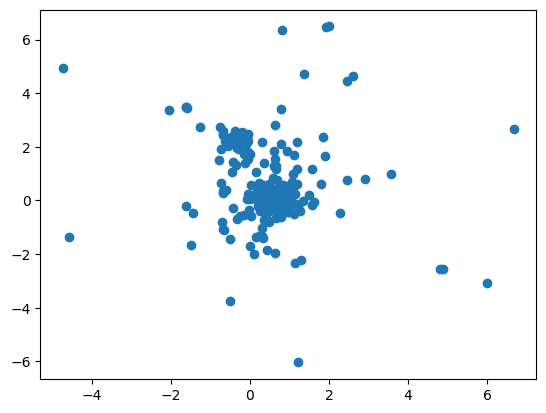

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
x = pos[:,0]
y = pos[:, 1]
plt.plot(x, y, "o")
delta = 0
delta  = 2e-1
labels = scan_df("selected_terms").select("term").collect().get_column("term")
# for i, label in enumerate(labels):
#     plt.text(x[i], y[i] - i * delta, label)
plt.show()

In [25]:
import matplotlib.pyplot as plt
%matplotlib
x = pos[:,0]
y = pos[:, 1]
plt.plot(x, y, "o")
delta = 0
# delta  = 2e-1
labels = scan_df("selected_terms").select("term").collect().get_column("term")
for i, label in enumerate(labels):
    plt.text(x[i], y[i] - i * delta, label)
plt.show()

Using matplotlib backend: GTK3Agg


/home/moonlyss/conda/envs/3.12/lib/python3.12/site-packages/ipykernel/gui/gtk3embed.py:65: RuntimeWarning: coroutine 'Kernel.do_one_iteration' was never awaited
  self.kernel.do_one_iteration()
